In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [2]:
import os
import pandas as pd

# set the directory path where the csv files are located
dir_path = './'

# get a list of all csv files in the directory
csv_files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]

# create an empty dictionary to store the dataframes
dfs = {}

# loop through each csv file and read it into a dataframe
for file in csv_files:
    # get the name of the file without the extension
    name = file.split('.')[0]
    # read the csv file into a dataframe
    df = pd.read_csv(os.path.join(dir_path, file))
    # add the dataframe to the dictionary with the file name as the key
    dfs[name] = df

In [3]:
# Print the shape of the dataset
weather_data = dfs['weather_data']
sensor_readings = dfs['sensor_readings']
leak_locations_and_rate = dfs['leak_locations_and_rate']
curr_df = weather_data
print("Shape of the dataset: ", curr_df.shape)

Shape of the dataset:  (86401, 6)


In [4]:
time_classification_map = {}
for index, row in leak_locations_and_rate.iterrows():
    for i in range(row['tStart'], row['tEnd'] + 1):
        time_classification_map[i] = True

def get_leak_location_and_rate(time):
    return time_classification_map.get(time, False)

In [5]:
# create a numpy array with the same shape as detection_input
data = np.empty((24*86401, 2), dtype=object)

# loop through each row in sensor_readings dataframe
outer_index = 0
for index, row in sensor_readings.iterrows():
    # loop through each sensor in the row
    for col in sensor_readings.columns:
        if col not in ['Unnamed: 0', 'time']:
            value = row[col]
            leak_probability = 0 if get_leak_location_and_rate(row['time']) else 1
            data[outer_index] = [value, leak_probability]
            outer_index += 1
            
    if index % 10000 == 0:
        print(index)

0
10000
20000
30000
40000
50000
60000
70000
80000


In [6]:
# create the dataframe from the numpy array
detection_input = pd.DataFrame(data, columns=['value', 'leak_probability'])

# print the new dataframe
print(detection_input.head())

    value leak_probability
0  1030.0                1
1  1049.0                1
2  1166.0                1
3   964.0                1
4  1023.0                1


In [7]:
# remove rows with all values none
detection_input = detection_input.dropna()

In [9]:
# If necessary, convert 'leak_probability' to numerical or categorical format
detection_input['leak_probability'] = detection_input['leak_probability'].astype('int')

Accuracy:  0.8045693319266505
              precision    recall  f1-score   support

           0       0.86      0.73      0.79    181514
           1       0.77      0.88      0.82    181515

    accuracy                           0.80    363029
   macro avg       0.81      0.80      0.80    363029
weighted avg       0.81      0.80      0.80    363029



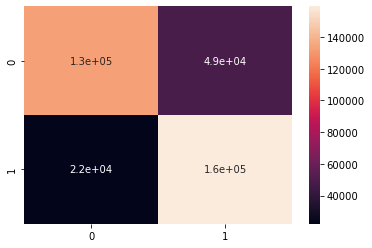

In [12]:
# train a random forest classifier on the data to see how well it can predict leak probability
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedShuffleSplit

# define the number of folds
k = 1

# split x and y
X = detection_input.drop(columns=['leak_probability'])
y = detection_input['leak_probability']

# implement SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# create a KFold object
kf = StratifiedShuffleSplit(n_splits=k, random_state=None)

# remeber best model
best_model = None
best_model_accuracy = 0

# split the data into k folds
for train_index, test_index in kf.split(X, y):
    # get the training and testing data for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train the decision tree classifier on the training data
    clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

    # scaling the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # fit the model
    clf.fit(X_train, y_train)

    # make predictions on the testing data
    y_pred = clf.predict(X_test)

    # calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)

    if accuracy > best_model_accuracy:
        best_model = clf
        best_model_accuracy = accuracy

    # print the classification report
    print(classification_report(y_test, y_pred))

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()

In [13]:
# pickle the model
import pickle
filename = 'random_forest_detection_model.sav'
pickle.dump(best_model, open(filename, 'wb'))